In [188]:
# data manipulation
import numpy as np
import pandas as pd
# clustering algo
from sklearn.cluster import KMeans
# visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# printing results
import matplotlib.pyplot as plt
# encoding labels
from sklearn.preprocessing import LabelEncoder
# progress bar
from tqdm.notebook import tqdm_notebook
# scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# loading python objects
import pickle

In this notebook I'm going to do a cluster analysis of the dataset using the features extracted with elaboration.ipybn.<br>The visualization is done by using log mel-spectrograms since is no reccommended using directly the MFCC because the DCT step decorellates the features. Istead MFCC+delta are used to apply clustering.

# Loading data

We start by loading the metadata of our pre-processed containing all the information...

In [2]:
metadata = pd.read_csv("processed_metadata.csv")
metadata.head()

,path,segment,label,samplingrate,ms
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,3000.0
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,3000.0
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,3000.0
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,3000.0
4,./Labelled/Bleatings/evt_000_000_000681_210415...,4,Bleatings,16000,3000.0


... and extract the label for each sample.

In [3]:
# Separating out the target
y = metadata['label']
#Scaling the feature columns
encoder = LabelEncoder()
y = encoder.fit_transform(y)
np.shape(y)

(6639,)

Next the data of the log mel spetrograms are loaded

In [4]:
logmelspectrograms = pickle.load(open("logmelspectrograms_data.p", "rb" ))
np.shape(logmelspectrograms)

(6639, 128, 94)

Since the samples are in tabular form is compulsory to flatten each matrix to a single row

In [6]:
logmelspectrograms = [sample.flatten() for sample in logmelspectrograms]
np.shape(logmelspectrograms)

(6639, 12032)

Next standardize each column to apply PCA afterwards

In [7]:
scaler = StandardScaler()
logmelspectrograms = scaler.fit_transform(logmelspectrograms)

Load MFCC and delta-MFCC features for k-means

In [8]:
features = pd.read_csv("mfcc_deltamfcc_entire.csv", index_col='Unnamed: 0')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,-498.372785,70.558003,-17.394419,22.370149,-2.773349,-8.818175,-3.375472,-3.880317,0.060479,-5.638018,...,-9.810652,-15.771450,-9.511748,-4.777353,-3.628776,-8.057930,-7.059937,-5.427528,-9.378248,-2.965233
1,-461.939744,94.490370,-30.162219,19.772600,-8.361755,0.029626,-1.496660,-4.535218,-1.276991,-2.467174,...,-12.708980,-9.712587,-9.239233,-6.313464,-6.577796,-4.884297,-5.886631,-5.312574,-3.758418,-6.700661
2,-529.540707,80.446150,-29.131353,20.216969,0.571056,-8.416232,-5.676588,-8.621220,-1.333912,-5.050858,...,-10.555406,-11.804663,-6.711576,-3.423953,-6.255485,-4.667065,-7.142622,-6.389498,-5.132346,-4.865369
3,-616.144775,50.042843,-27.797401,10.828676,-0.034238,-3.344975,-5.781679,-5.397288,-0.332126,-4.466050,...,-9.258957,-8.813666,-5.116341,-2.900284,-2.844657,-2.890104,-4.251687,-2.681928,-4.668478,-2.775859
4,-471.954266,115.457746,-22.104456,24.454849,-5.564850,2.889188,6.143604,0.236881,-3.250076,-0.004432,...,-10.568315,-10.561276,-8.527216,-5.587518,-7.701231,-6.702233,-6.928992,-5.485289,-7.765387,-6.183199


In [189]:
features = scaler.fit_transform(features)

# Visualization

Let's start by defining a way to visualize our dataset. A good starting point is to take the 2 principal component obtained by PCA over the logmelspectrograms data and plot them.

In [9]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(logmelspectrograms)
pca.explained_variance_ratio_

array([0.39923501, 0.1461488 ])

The 2 principal component only explain about 54% of the variance in data.<br>Let's plot the obtained axis.

In [52]:
def print_axis(components, targets):
    plt.figure(figsize = (12,8))
    scatter = plt.scatter(components[:, 0], components[:, 1], c=targets, alpha=0.5)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    targets = [0,1,2]
    plt.legend(*scatter.legend_elements())

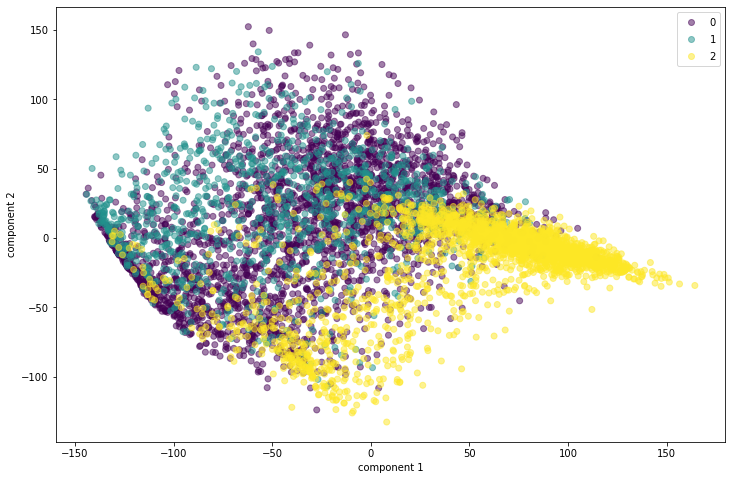

In [53]:
print_axis(principalComponents, y)

The plot is a bit messy... let's try to improve the printing by using T-SNE.<br>To further reduce the noise and speed-up the computation I extract the 50 principal components obtained by PCA and use them for T-SNE.

In [12]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(logmelspectrograms)
np.sum(pca.explained_variance_ratio_)

0.9037180881553089

This time we captured 90% of variance in data!<br>Apply t-sne over the transformed data and print the result.

In [13]:
components = TSNE(n_components=2, random_state=50).fit_transform(principalComponents)

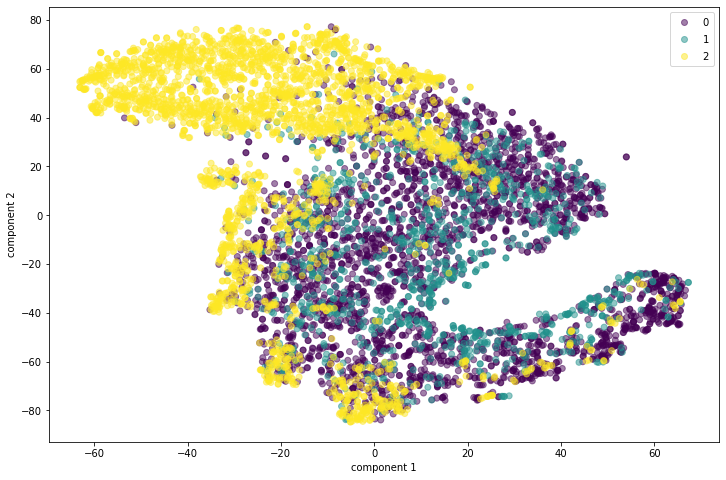

In [54]:
print_axis(components, y)

This way we obtained a slightly better rapprensetation of data! The label 2 (Others) is the most separeted from the others while the others 2 are mixed up, like seen with PCA.

# Clustering

Let's do basic cluster analysis with k-means to learn more about the difficulty of the problem.<br>I dont excpet very good result since the dataset in pretty imbalanced.

In [190]:
kmeans = KMeans(n_clusters=3, random_state=1234).fit(features)
labels = pd.Series(kmeans.labels_)
np.shape(labels)

(6639,)

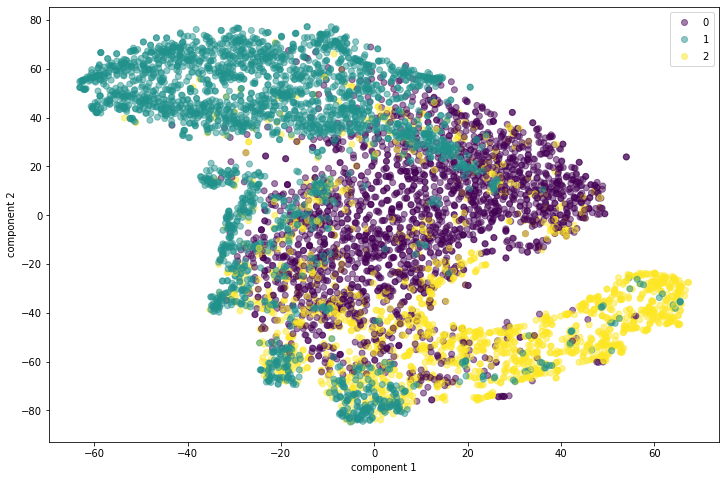

In [192]:
print_axis(components, labels)

Let's put in a list, for each identified class by the clustering, the index of the associated item.

In [219]:
classes = [list(), list(), list()]
for count, label in enumerate(labels):
    if label == 0:
        classes[0].append(count)
    elif label == 1:
        classes[1].append(count)
    else:
        classes[2].append(count)
print(len(classes[0]), len(classes[1]), len(classes[2]))

2228 2674 1737


And count for each element in the identfied clusters in which original labels falls the point

In [218]:
def count_for_class(classes):
    counts = [list(), list(), list()]
    for i in classes:
        if y[i] == 0:
            counts[0].append(i)
        elif y[i] == 1:
            counts[1].append(i)
        else:
            counts[2].append(i)
    return (len(counts[0]), len(counts[1]), len(counts[2]))

(1656, 572, 0)

In [236]:
for i in range(3):
    count = count_for_class(classes[i])
    print(f"For the cluster {i} we have {count} items in the orignal classes\tThe most promising original class is {np.argmax(count)}")

For the cluster 0 we have (1656, 572, 0) items in the orignal classes	The most promising original class is 0
For the cluster 1 we have (15, 3, 2656) items in the orignal classes	The most promising original class is 2
For the cluster 2 we have (1169, 520, 48) items in the orignal classes	The most promising original class is 0


As can see above, since almost all the points in the cluster 1 are of the class 2, we can correct the color of the labels by inveriting the 1 with 2. Istead none can be said about the other two since the they are pretty mixed up and by majority both cotains most class 0 labels. However since in % the cluster 0 contains more samples of class 0 i've decided to leave this as it is and assign to cluster 2 label's 1.

In [237]:
# modify obtained labels to reflect the original
modlabels = [2 if l==1 else 1 if l==2 else 0 for l in labels]

In [238]:
pd.concat((pd.Series(y).value_counts().rename("Original"), pd.Series(modlabels).value_counts().rename("K-means")), axis=1)

,Original,K-means
0,2840,2228
1,1095,1737
2,2704,2674


Let's visualize both T-SNE and PCA

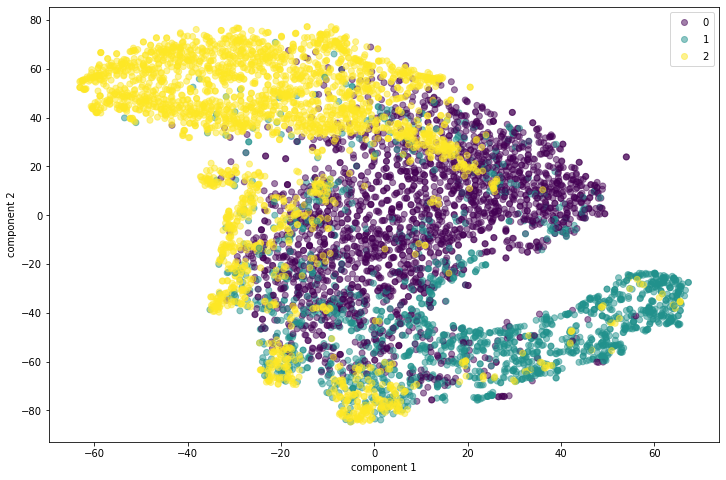

In [239]:
print_axis(components, modlabels)

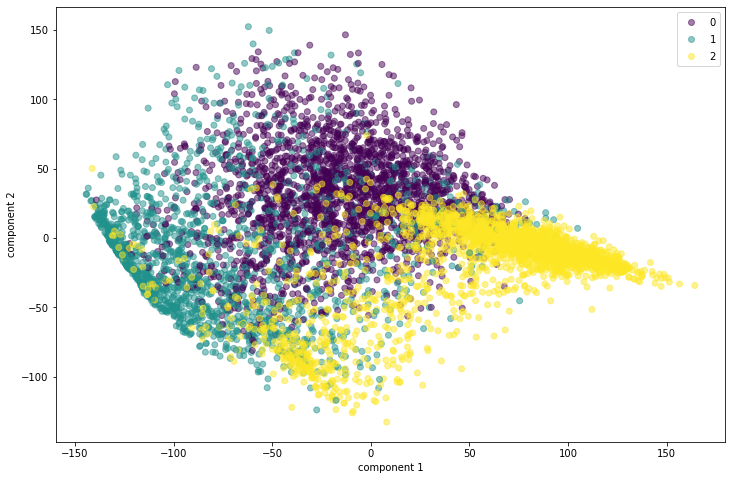

In [240]:
print_axis(principalComponents, modlabels)

By using 3 clusters, we can see in the plots and in the above conclusion about the counts of the elements in clusters that most of the "other" record get correctrly clustered from the others, but the others two class which in the orginal dataset are pretty mixed up with k-means they get separated in two distinct clusters.<br>Let's have a deep look in the changing of the label between the original data and clustering.

In [242]:
diff = (pd.Series(y)).compare(pd.Series(modlabels))
print(f"{len(diff)} elements change label out of {len(y)}")
diff.head()

1807 elements change label out of 6639


,self,other
3,0.0,1.0
5,0.0,1.0
7,0.0,1.0
9,0.0,1.0
10,0.0,1.0


In [243]:
differences = [f'{row[0]} -> {row[1]}' for row in diff.to_numpy()]
pd.Series(differences).value_counts()

0.0 -> 1.0    1169
1.0 -> 0.0     572
2.0 -> 1.0      48
0.0 -> 2.0      15
1.0 -> 2.0       3
dtype: int64

As previously assumed we can see almost none of the items with label 2 (others) change label and even less change in 2. This is probably due the fact that I've removed the noise from the first two class and no in others by making this label features very different.<br>The most interesting and worrying thing is that a lot of labels change values from  0 (bleatings) to 1 (contact calls) and vice versa. This means that this two class are a bit mixed up (as can also be seen in the plot) and this ca be a problem for our classification task.